In [2]:
import pandas as pd 
import numpy as np 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score

#importing nltk and stopwords 
import nltk
from nltk.corpus import stopwords


import string 
import json
import re
import glob

In [3]:
# creating a fucntion to read the file 
def load_data(path):
    with open(path, 'r', encoding="utf-8")as f:
        data = json.load(f)
        return data 
    

# creating a function to write into the file 

def write_data(path):
    with open(path,'w', encoding="utf-8") as f:
        json.dump(data,f, indent=4)

In [4]:
# Let's create a function to remove the stopwords 
def remove_stops(text, stops):
    text = re.sub(r"AC\/\d{1,4}\/\d{1,4}", "", text)
    words = text.split()
    final = []
    for word in words:
        if word not in stops:
            final.append(word)
    final = " ".join(final)
    final = final.translate(str.maketrans("", "", string.punctuation))
    final = "".join([i for i in final if not i.isdigit()])
    while "  " in final:
        final = final.replace("  ", " ")
    return (final)

In [5]:
# let's now load the data 
descriptions = load_data('data/trc_dn.json')['descriptions']
names = load_data('data/trc_dn.json')['names']

In [6]:
# Let's create a function to clean the data 

def clean_docs(docs):
    stops = stopwords.words("english")
    months = load_data("data/months.json")
    stops = stops+months
    final = []
    for doc in docs:
        clean_doc = remove_stops(doc, stops)
        final.append(clean_doc)
    return (final)

In [7]:
# let's do the cleaning 
cleaned_docs = clean_docs(descriptions)

In [8]:
cleaned_docs

['An ANCYL member shot severely injured SAP members Lephoi Bethulie Orange Free State OFS Police opened fire gathering ANC supporters house following dispute two neighbours one linked ANC SAP councillor',
 'A member SADF severely injured landmine explosion Messina Transvaal ',
 'A member QIBLA disappeared fleeing country political reasons He detained several times left South Africa',
 'A COSAS supporter kicked beaten batons riflebutts members Ciskei Police protests Ciskei government Zwelitsha Mdantsane Ciskei ',
 'Was shot blinded one eye members SAP Athlone Cape Town Soweto uprising',
 'Was shot injured members SAP Robertson Cape Police fired teargas crowded hall residents meeting Over one hundred people treated injuries relating subsequent stampede shootings',
 'Was shot injured members Railway Police Athlone Trojan Horse incident Cape Town',
 'A street committee member shot dead members SAP Gelvandale Port Elizabeth ',
 'An MK member went exile His family last heard received conflic

In [9]:
# Let's now vectorize the data using Tf-IDF

vectorizer = TfidfVectorizer(
                                lowercase=True,
                                max_features= 50,
                                max_df=0.8, # any word that is present with 80% ignore that words 
                                min_df=5 ,# ignorning the words with the frequency less than 5
                                ngram_range=(1,3),
                                stop_words="english"


)

vector = vectorizer.fit_transform(cleaned_docs)

# let's get the features names 
feature_names = vectorizer.get_feature_names_out()

# creating dense vector
dense = vector.todense()
# converting dense into a list 
denselist = dense.tolist()

all_keywords=[]

for description in denselist:
    x=0
    keywords = []
    for word in description:
        if word > 0:
            keywords.append(feature_names[x])
        x=x+1
    all_keywords.append(keywords)
print (descriptions[0])
print (all_keywords[0])





#


An ANCYL member who was shot and severely injured by SAP members at Lephoi, Bethulie, Orange Free State (OFS) on 17 April 1991. Police opened fire on a gathering at an ANC supporter's house following a dispute between two neighbours, one of whom was linked to the ANC and the other to the SAP and a councillor.
['anc', 'anc supporters', 'house', 'injured', 'member', 'members', 'police', 'sap', 'severely', 'shot', 'supporters']


In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [11]:
#modelling the topic cluster using k means 

true_k = 5

model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)

model.fit(vector)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

with open ("data/trc_results.txt", "w", encoding="utf-8") as f:
    for i in range(true_k):
        f.write(f"Cluster {i}")
        f.write("\n")
        for ind in order_centroids[i, :10]:
            f.write (' %s' % terms[ind],)
            f.write("\n")
        f.write("\n")
        f.write("\n")

In [12]:
# silhouette score
print(silhouette_score(vector, model.labels_))

0.09367466725931238


In [15]:
## Plotting the clusters using matplotlib

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


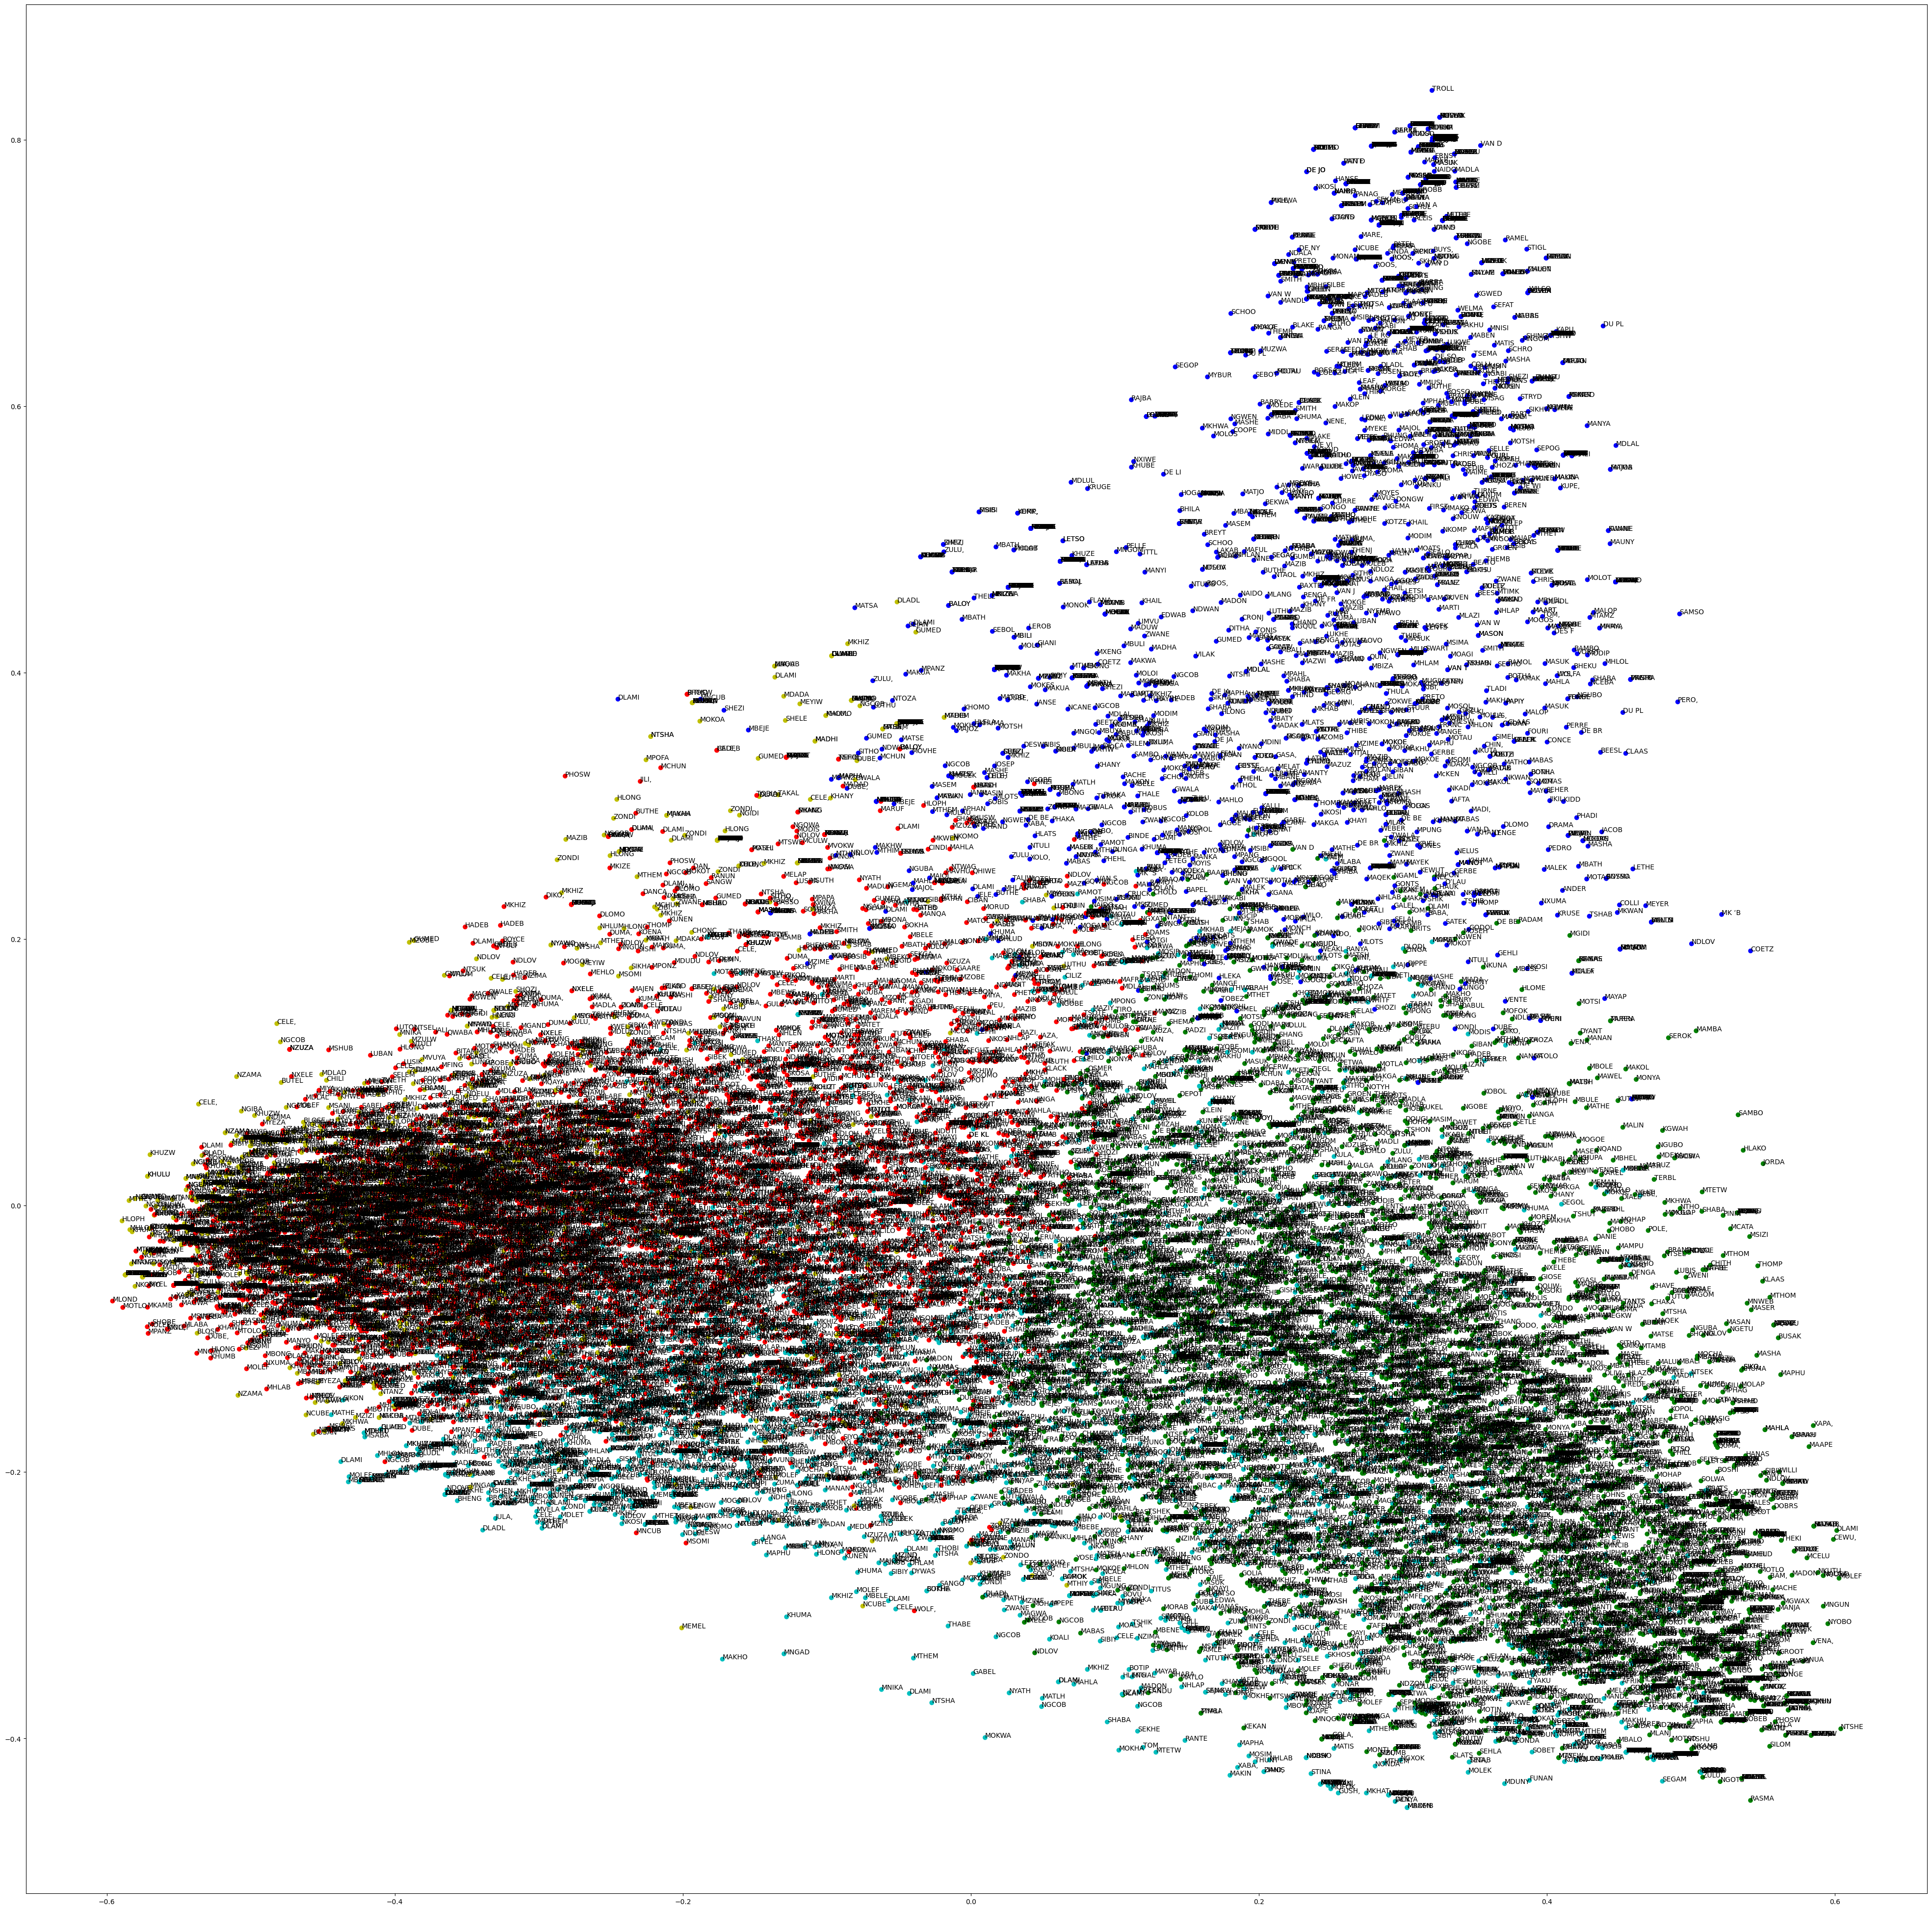

In [14]:
kmeans_indices= model.fit_predict(vector)
pca = PCA(n_components=2)

scatter_plot_points = pca.fit_transform(vector.toarray())
colors=['r','b','g','c','y']
x_axis=[o [0] for o in scatter_plot_points]

y_axis=[o [1] for o in scatter_plot_points]

fig, ax = plt.subplots(figsize=(50,50))

ax.scatter(x_axis, y_axis, c=[colors[d] for d in kmeans_indices])

for i, txt in enumerate(names):
    ax.annotate(txt[0:5], (x_axis[i], y_axis[i]))

plt.savefig("data/cluster.png")
plt.show()